# Navie Bayes Assignment

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [3]:

# using SQLite Table to read data.
con = sqlite3.connect('/content/drive/My Drive/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 200000 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)


Number of data points in our data (200000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head(2)

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

##  Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(160178, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

80.089

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(160176, 10)


1    134799
0     25377
Name: Score, dtype: int64

## Preprocessing

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more g

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.
The qualitys not as good as the lamb and rice but it didn't seem to bother his stomach, you get 10 more pounds and it is cheaper wich is a plus for me. You can always ad your own rice and veggies. Its fresher that way and better for him in my opinion. Plus if you you can get it deliverd to your house for free its even better.  Gotta love pitbulls
This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and"ko-"  is "child of" or of "derived from".) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.
What can I say..

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is the Japanese version of breadcrumb (pan=bread, a Portuguese loan-word, and&quot;ko-&quot;  is &quot;child of&quot; or of &quot;derived from&quot;.) Panko are used for katsudon, tonkatsu or cutlets served on rice or in soups. The cutlets, pounded chicken or pork, are coated with these light and crispy crumbs and fried. They are not gritty and dense like regular crumbs. They are very nice on deep fried shrimps and decorative for a more gourmet touch.


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I remembered this book from my childhood and got it for my kids.  It's just as good as I remembered and my kids love it too.  My older daughter now reads it to her sister.  Good rhymes and nice pictures.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is the Japanese version of breadcrumb pan bread a Portuguese loan word and quot ko quot is quot child of quot or of quot derived from quot Panko are used for katsudon tonkatsu or cutlets served on rice or in soups The cutlets pounded chicken or pork are coated with these light and crispy crumbs and fried They are not gritty and dense like regular crumbs They are very nice on deep fried shrimps and decorative for a more gourmet touch 


In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
import warnings
warnings.filterwarnings("ignore")
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 160176/160176 [01:02<00:00, 2542.50it/s]


In [24]:
final['CleanedText']=preprocessed_reviews
final.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,1025481600,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,0,1129507200,awesome book poor size,This is one of the best children's books ever ...,one best children books ever written mini vers...


In [25]:
final['Score'].value_counts()

1    134799
0     25377
Name: Score, dtype: int64

1 as positive <br>
0 as negative

In [0]:
data=final.sample(100000)

In [27]:
print("For 100000 samples :\n" , data['Score'].value_counts())

For 100000 samples :
 1    84117
0    15883
Name: Score, dtype: int64


In [28]:
#Sorting According to Time
data["Time"] = pd.to_datetime(data["Time"], unit = "s")
data = data.sort_values(by ="Time",axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,1999-10-08,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,1999-10-25,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,2000-01-24,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
138001,149770,B00004S1C5,A1KXONFPU2XQ5K,Stephanie Manley,8,8,1,2000-08-09,Very easy to use,This are so much easier to use than the Wilson...,much easier use wilson paste colors colors vib...
138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,1,2000-12-05,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,sick scads nasty toothpicks counter tinting ic...
138018,149790,B00004S1C6,A1IU7S4HCK1XK0,Joanna Daneman,25,27,1,2001-02-22,Make your own Martha Stewart style cakes and c...,I don't know why anyone would ever use those l...,not know anyone would ever use little liquid f...
138020,149792,B00004S1C6,A3B5QJVM1TLYJG,Dan Crevier,11,12,1,2001-10-23,"Nice, bright colors!",I bought these to decorate some dia de los mue...,bought decorate dia de los muertos skulls icin...
138682,150500,0006641040,A1IJKK6Q1GTEAY,A Customer,2,2,1,2001-12-26,It Was a favorite!,This was a favorite book of mine when I was a ...,favorite book mine little girl would read time...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,2002-04-10,A great way to learn the months,This is a book of poetry about the months of t...,book poetry months year goes month cute little...
138707,150525,0006641040,A2QID6VCFTY51R,Rick,1,2,1,2002-07-01,"In December it will be, my snowman's anniversa...","My daughter loves all the ""Really Rosie"" books...",daughter loves really rosie books introduced r...


In [0]:
# this is for 100k points
X=data['CleanedText']
y=data['Score']

In [30]:
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3) #random splitting
X_train,X_cv,y_train,y_cv= train_test_split(X_train, y_train, test_size=0.33) # random splitting
print(X_train.shape, y_train.shape)
print(X_cv.shape, y_cv.shape)
print(x_test.shape, y_test.shape)

(46900,) (46900,)
(23100,) (23100,)
(30000,) (30000,)


## Bag of words

In [31]:
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer(binary=True,max_features=2000,dtype='float').fit(X_train)
X_train_bow = bow.transform(X_train)
X_train_bow

<46900x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1266382 stored elements in Compressed Sparse Row format>

In [0]:
x_test_bow = bow.transform(x_test)
X_cv_bow=bow.transform(X_cv)

In [33]:
print("After vectorizations")
print(X_train_bow.shape, y_train.shape)
print(X_cv_bow.shape, y_cv.shape)

After vectorizations
(46900, 2000) (46900,)
(23100, 2000) (23100,)


In [0]:
from sklearn.naive_bayes import MultinomialNB
from collections import Counter
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

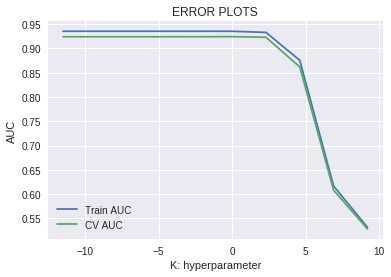

In [35]:
from pylab import scatter
import pylab
import math

train_auc = []
cv_auc = []
K = [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for i in K:
    neigh = MultinomialNB(alpha=i)
    neigh =neigh.fit(X_train_bow, y_train)
    y_train_pred =  neigh.predict_proba(X_train_bow)[:,1]
    y_cv_pred =  neigh.predict_proba(X_cv_bow)[:,1]
    
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

#plt.plot(np.log(K), train_auc, label='Train AUC')
plt.plot(list(map(lambda x:math.log(x),K)), train_auc, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),K)), cv_auc, label='CV AUC')
#plt.plot(np.log(K), cv_auc, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [36]:
# determining best alpha using train score
optimal_alpha = K[train_auc.index(max(train_auc))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha)
print('-'*100)

#Test_Auc=[test_auc]
# determining best alpha using test score(cv score)
optimal_alpha1 = K[cv_auc.index(max(cv_auc))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha1) # Using this as optimal alpha


The optimal number of alpha is 0.000010.
----------------------------------------------------------------------------------------------------

The optimal number of alpha is 1.000000.


In [37]:
# instantiate learning model alpha = optimal_alpha
nb_optimal = MultinomialNB(alpha = optimal_alpha1)
# fitting the model
nb_optimal.fit(X_train_bow, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [38]:
# predict the response
pred_bow = nb_optimal.predict(x_test_bow)


bow_features = bow.get_feature_names() # To get all the features names

# Empirical log probability of features given a class(i.e. P(x_i|y))
log_prob = nb_optimal.feature_log_prob_

feature_prob_bow = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr_bow = feature_prob_bow.T
feature_prob_tr_bow.shape

(2000, 2)

In [39]:
# To show top 10 feature from both class
# Feature Importance

print("Top 10 Negative Features:-\n",(feature_prob_tr_bow[0]).sort_values(ascending = False)[0:10])

print("\n\n Top 10 Positive Features:-\n",(feature_prob_tr_bow[1]).sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -3.633243
like      -4.379963
would     -4.538821
taste     -4.631975
product   -4.668898
one       -4.771810
good      -4.902883
no        -5.020428
flavor    -5.099758
even      -5.182570
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not       -3.975045
like      -4.540175
good      -4.580392
great     -4.593106
one       -4.821001
taste     -4.858651
love      -4.877463
would     -4.986180
product   -4.991730
flavor    -4.993680
Name: 1, dtype: float64


In [40]:
pred_bow1=nb_optimal.predict(X_train_bow)
# evaluate accuracy on test data
from sklearn.metrics import roc_auc_score
auc_bow = roc_auc_score(y_test, pred_bow)
print('\nThe Test Auc of the naive bayes classifier for alpha = %f is %f%%' % (optimal_alpha1, auc_bow))


The Test Auc of the naive bayes classifier for alpha = 1.000000 is 0.808721%


[[ 3173  1524]
 [ 1470 23833]]
   


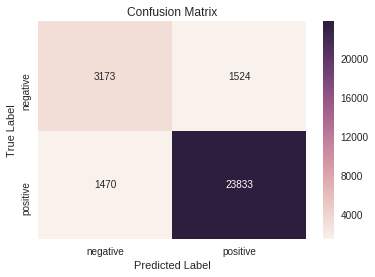

***************************************************************************
[[ 5253  2212]
 [ 2216 37219]]
   


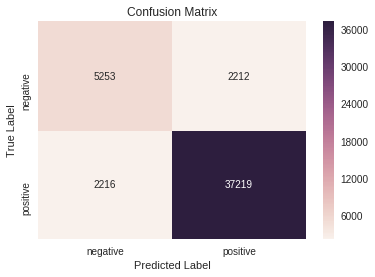

In [41]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_bow = confusion_matrix(y_test, pred_bow)
print(cm_bow)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm_bow, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('***************************************************************************')

cm_bow1 = confusion_matrix(y_train, pred_bow1)
print(cm_bow1)
print('   ')
# plotting confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label1 = ["negative", "positive"]
df_cm1 = pd.DataFrame(cm_bow1, index = class_label1, columns = class_label1)
sns.heatmap(df_cm1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
print("Tp , Tn , Fp , Fn")
confusion=cm_bow.ravel()
confusion[0]

Tp , Tn , Fp , Fn


3173

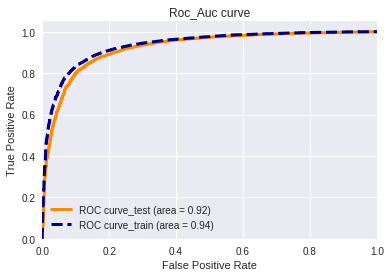

In [43]:
### Compute ROC curve and ROC area for predictions on validation set
from sklearn import metrics
y_test_predict =  nb_optimal.predict_proba(x_test_bow)[:,1]
y_train_predict = nb_optimal.predict_proba(X_train_bow)[:,1]
fpr1,tpr1,_ =  metrics.roc_curve(y_train,y_train_predict) 
fpr,tpr, _ = metrics.roc_curve(y_test,y_test_predict)

roc_auc = auc(fpr, tpr) 
roc_auc1 = auc(fpr1,tpr1) 
### Plot
plt.figure()
lw = 3
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc)
plt.plot(fpr1,tpr1, color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

In [44]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_bow))
print('**'*50)
print(classification_report(y_train, pred_bow1))

              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4697
           1       0.94      0.94      0.94     25303

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.81      0.81      0.81     30000
weighted avg       0.90      0.90      0.90     30000

****************************************************************************************************
              precision    recall  f1-score   support

           0       0.70      0.70      0.70      7465
           1       0.94      0.94      0.94     39435

   micro avg       0.91      0.91      0.91     46900
   macro avg       0.82      0.82      0.82     46900
weighted avg       0.91      0.91      0.91     46900



## Tf-Idf

In [45]:
tf_idf_vect = TfidfVectorizer(min_df=10,max_features=2000 , ngram_range=(1,2)).fit(X_train)
X_train_tfidf = tf_idf_vect.transform(X_train)
X_train_tfidf

<46900x2000 sparse matrix of type '<class 'numpy.float64'>'
	with 1327263 stored elements in Compressed Sparse Row format>

In [0]:
# Convert test text data to its vectorizor
x_test_tfidf = tf_idf_vect.transform(x_test)
X_cv_tfidf=tf_idf_vect.transform(X_cv)

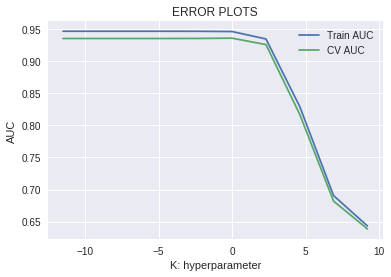

In [47]:
train_auc1 = []
cv_auc1 = []
K1 =  [0.00001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
for j in K1:
    neigh_tfidf= MultinomialNB(alpha=j)
    neigh_tfidf.fit(X_train_tfidf, y_train)
    y_train_pred_tfidf = neigh_tfidf.predict_proba(X_train_tfidf)[:,1]
    y_cv_pred_tfidf =  neigh_tfidf.predict_proba(X_cv_tfidf)[:,1]
    
    train_auc1.append(roc_auc_score(y_train,y_train_pred_tfidf))
    cv_auc1.append(roc_auc_score(y_cv, y_cv_pred_tfidf))

plt.plot(list(map(lambda x:math.log(x),K1)), train_auc1, label='Train AUC')
plt.plot(list(map(lambda y:math.log(y),K1)), cv_auc1, label='CV AUC')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [48]:

# determining best alpha
optimal_alpha_tfidf = K1[train_auc1.index(max(train_auc1))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha_tfidf)
print('-'*100)
# determining best alpha
optimal_alpha1_tfidf = K1[cv_auc1.index(max(cv_auc1))]
print('\nThe optimal number of alpha is %f.' % optimal_alpha1_tfidf)


The optimal number of alpha is 0.000010.
----------------------------------------------------------------------------------------------------

The optimal number of alpha is 1.000000.


In [49]:
# instantiate learning model alpha = optimal_alpha
nb_optimal_tfidf = MultinomialNB(alpha = optimal_alpha1_tfidf)
nb_optimal_tfidf

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [0]:

# fitting the model
nb_optimal_tfidf.fit(X_train_tfidf, y_train)

predict_tfidf = nb_optimal_tfidf.predict(x_test_tfidf)
predict_tfidf1=nb_optimal_tfidf.predict(X_train_tfidf)

In [51]:
tfidf_features = tf_idf_vect.get_feature_names() # to get features 

# Empirical log probability of features given a class(i.e. P(x_i|y))

log_prob_tfidf = nb_optimal_tfidf.feature_log_prob_

feature_prob_tfidf = pd.DataFrame(log_prob_tfidf, columns = tfidf_features)
feature_prob_tr_tfidf = feature_prob_tfidf.T
feature_prob_tr_tfidf.shape

(2000, 2)

In [52]:
print("Top 10 Negative Features:-\n",feature_prob_tr_tfidf[0].sort_values(ascending = False)[0:10])

print("\n\n Top 10 Positive Features:-\n",feature_prob_tr_tfidf[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -4.089812
like      -4.904663
product   -4.963736
would     -5.028867
taste     -5.048430
coffee    -5.226847
one       -5.322172
no        -5.468455
flavor    -5.480638
good      -5.550094
Name: 0, dtype: float64


 Top 10 Positive Features:-
 not       -4.642950
great     -4.984144
good      -5.049081
like      -5.104801
coffee    -5.120633
love      -5.206123
tea       -5.247799
product   -5.320564
one       -5.335830
taste     -5.347024
Name: 1, dtype: float64


In [53]:
auc_tfidf = roc_auc_score(y_test, predict_tfidf)
print('\nThe Test Auc of the naive bayes classifier for alpha = %f is %f%%' % (optimal_alpha1_tfidf, auc_tfidf))


The Test Auc of the naive bayes classifier for alpha = 1.000000 is 0.623945%


[[ 1179  3518]
 [   79 25224]]




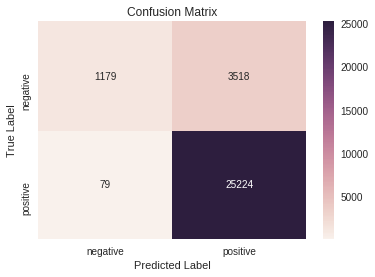

****************************************************************************************************
[[ 1991  5474]
 [  114 39321]]




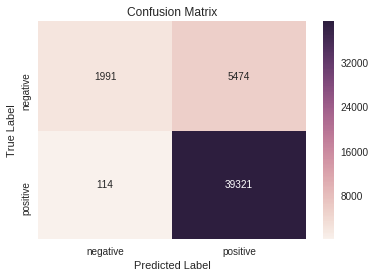

In [54]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test,predict_tfidf)
print(conf_matrix)
print('\n')
class_label_tfidf = ["negative", "positive"]
df_cm_tfidf = pd.DataFrame(conf_matrix, index = class_label_tfidf, columns = class_label_tfidf)
sns.heatmap(df_cm_tfidf, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print('**'*50)
conf_matrix1 = confusion_matrix(y_train,predict_tfidf1)
print(conf_matrix1)
print('\n')
class_label_tfidf1 = ["negative", "positive"]
df_cm_tfidf1 = pd.DataFrame(conf_matrix1, index = class_label_tfidf1, columns = class_label_tfidf1)
sns.heatmap(df_cm_tfidf1, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

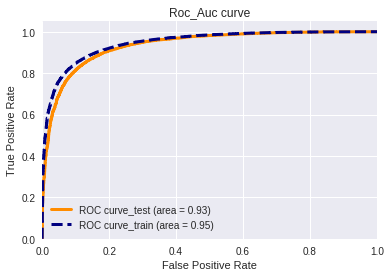

In [55]:
### Compute ROC curve and ROC area for predictions on validation set
from sklearn import metrics
y_test_predict_tfidf =  nb_optimal_tfidf.predict_proba(x_test_tfidf)[:,1]
y_train_predict_tfidf =  nb_optimal_tfidf.predict_proba(X_train_tfidf)[:,1]
fpr1_tfidf,tpr1_tfidf,_ =  metrics.roc_curve(y_train,y_train_predict_tfidf)
fpr_tfidf,tpr_tfidf,_ = metrics.roc_curve(y_test, y_test_predict_tfidf) 

roc_auc_tfidf = auc(fpr_tfidf,tpr_tfidf) 
roc_auc1_tfidf = auc(fpr1_tfidf,tpr1_tfidf)
### Plot
plt.figure()
lw = 3
plt.plot(fpr_tfidf,tpr_tfidf, color='darkorange',
         lw=lw, label='ROC curve_test (area = %0.2f)' % roc_auc_tfidf)
plt.plot(fpr1_tfidf,tpr1_tfidf , color='navy', lw=lw, linestyle='--',label='ROC curve_train (area = %0.2f)' % roc_auc1_tfidf)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Roc_Auc curve')
plt.legend()
plt.show()

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predict_tfidf))
print(classification_report(y_train, predict_tfidf1))

              precision    recall  f1-score   support

           0       0.94      0.25      0.40      4697
           1       0.88      1.00      0.93     25303

   micro avg       0.88      0.88      0.88     30000
   macro avg       0.91      0.62      0.66     30000
weighted avg       0.89      0.88      0.85     30000

              precision    recall  f1-score   support

           0       0.95      0.27      0.42      7465
           1       0.88      1.00      0.93     39435

   micro avg       0.88      0.88      0.88     46900
   macro avg       0.91      0.63      0.67     46900
weighted avg       0.89      0.88      0.85     46900



 #### The final metric of Analysis for Navie bayes is clearly mentioned with above code and auc in below table.